# This is my custom trial
As I saw that the AlexNet has *strikingly* similar architecture with the *LeNet* I can't resist impulse to build it and train it on our Fashion data!

Let's test that out and check whether it can detect our age old "shoes" as "shoes"!
---

Most of the code will be similar in this notebook. So, hack yeah.

In [ ]:
!pip install d2l

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

<img src="../images/alexnet.svg">

The **left side** is our LeNet and the **right one** is the AlexNet.

In [3]:
def init_cnn(module):
    """
    Initialize weights for CNNs.

    This function will be called *module-by-module*. It will receive
    individiual layers and will then initialize it.

    We need to check whether their types are Linear or Conv2D
    else we will encounter an error for the Activation inits.
    """
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [3]:
class AlexNet(d2l.Classifier):
    """AlextNet model"""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(),
            nn.LazyLinear(4096), nn.ReLU(),
            nn.LazyLinear(num_classes))

In [ ]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    # basically we will need to *pass* something there as there are LazyLayers
    X = torch.randn(*X_shape, device="cuda")
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [ ]:
model = AlexNet().cuda()

# these are the **image outputs** between layers and **not** the parameters of the model to be learnt.
# model.layer_summary((1, 1, 28, 28))
model.layer_summary((1, 3, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 6, 6])
Flatten output shape:	 torch.Size([1, 9216])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


> The AlexNet will **not** work with the small images like 28x28 and will give the error. So, we will need to **resize** whole dataset.

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 58322314


In [ ]:
# Iterate through the model's layers and parameters
for name, layer in model.named_modules():
    # Check if the layer has parameters (e.g., Conv2d, Linear)
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        print(f"Layer: {name}")
        for param in layer.parameters():
            print(f"  Parameter: {param.shape}")

Layer: net.0
  Parameter: torch.Size([96, 3, 11, 11])
  Parameter: torch.Size([96])
Layer: net.3
  Parameter: torch.Size([256, 96, 5, 5])
  Parameter: torch.Size([256])
Layer: net.6
  Parameter: torch.Size([384, 256, 3, 3])
  Parameter: torch.Size([384])
Layer: net.8
  Parameter: torch.Size([384, 384, 3, 3])
  Parameter: torch.Size([384])
Layer: net.10
  Parameter: torch.Size([256, 384, 3, 3])
  Parameter: torch.Size([256])
Layer: net.14
  Parameter: torch.Size([4096, 9216])
  Parameter: torch.Size([4096])
Layer: net.16
  Parameter: torch.Size([4096, 4096])
  Parameter: torch.Size([4096])
Layer: net.18
  Parameter: torch.Size([10, 4096])
  Parameter: torch.Size([10])


Alright, bro, you’re staring at **58,322,314** trainable parameters—that’s a *shit ton*! Let’s break it down for some perspective:

### 1. **What Does This Number Mean?**
- These are the weights and biases across all the layers of AlexNet.
- Every parameter needs to be adjusted during training, which means your model is **massive** for a dataset like Fashion MNIST. It's designed for complex datasets like ImageNet, not simpler ones with tiny images.

---

### 2. **How Big is It Compared to Other Models?**
- **AlexNet**: ~58M parameters
- **VGG16**: ~138M parameters (even bigger)
- **ResNet-50**: ~25M parameters (much smaller but way more efficient)
- **LeNet-5 (classic for MNIST)**: ~60K parameters (tiny compared to AlexNet)

AlexNet is like bringing a bazooka to kill a mosquito. It’s *overkill* for Fashion MNIST, but if you're just testing, it’s fine. Just know it's gonna be heavy on your GPU/CPU.

---

### 3. **How Does It Impact Training?**
- **Memory Usage**: 58M parameters take up a lot of VRAM (or RAM if you're using a CPU). You need a decent GPU (preferably with at least 8GB of VRAM) or it’ll crawl.
- **Training Speed**: Since you're working with a smaller dataset, the model might overfit easily, and training could take much longer.

---

### 4. **How Big is the Model in Storage?**
Each parameter is typically stored as a 32-bit float:
- \( 58,322,314 \times 4 \text{ bytes (32 bits)} = ~233 \text{ MB} \)

The trained AlexNet model will take ~233 MB just for the weights.

---

### TL;DR:
**58M parameters = Huge!** It’s way too much for Fashion MNIST, but hey, if you’ve got the resources and patience, it’ll work. Just don’t expect it to be efficient, bro—it’s a beast!

## Resizing pipeline

In [4]:
class FashionMNIST(d2l.DataModule):
    """
    RULE: Whenever you're loading the data or doing something with it,
    try to *create* a class first.

    That will handle the stuff, like loading - giving batches - manipulating
    etc.

    It keeps the stuff handy.
    """
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__() # it will initialize self.root and num_workers (image above)
        self.save_hyperparameters()

        # ✨ this is the pipeline that we are setting **classic one!**
        trans = transforms.Compose([transforms.Resize(resize), # resize the image
                                    # transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels (RGB)
                                    transforms.ToTensor()])    # mamke it tensor-friendly

        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)

        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    def get_dataloader(self, train):
        """Defined in :numref:`sec_fashion_mnist`"""
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=self.num_workers)

In [ ]:
data = FashionMNIST(batch_size=128, resize=(224, 224))

In [ ]:
data.train[0][0].shape

torch.Size([1, 224, 224])

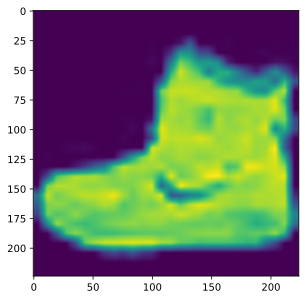

In [ ]:
plt.imshow(data.train[0][0].permute(1,2,0));

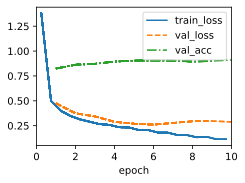

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model = AlexNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [ ]:
print(model.board.data['val_acc'][-1])

Point(x=10.0, y=0.9105023734177216)


# Loading the model

In [ ]:
loaded_model = AlexNet()
loaded_model.load_state_dict(torch.load('./AlexNet.params', weights_only=True))

<All keys matched successfully>

In [ ]:
loaded_model.cuda()

AlexNet(
  (net): Sequential(
    (0): LazyConv2d(0, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): LazyLinear(in_features=0, out_features=4096, bias=True)
    (15): ReLU()
    (16): LazyLinear(in_features=0, out_features=4096, bias=True)
    (17): ReLU()
    (18): LazyLinear(in_features=0, out_featur

In [ ]:
from torchvision import transforms
from PIL import Image

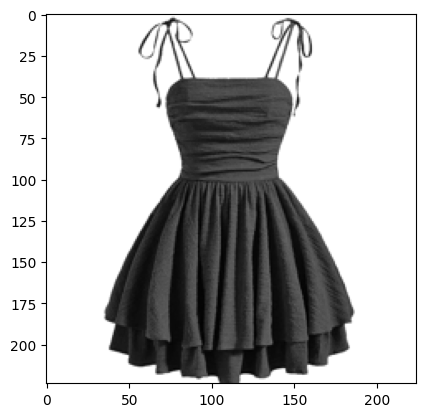

In [ ]:
image = Image.open('../images/dress-clean.png')  # Replace with your image path
image_resized = image.resize((224, 224))
transform = transforms.ToTensor()
image_resized = transform(image_resized)
plt.imshow(image_resized.squeeze(0), cmap="gray");

In [ ]:
image_resized = image_resized.reshape(1, 1, 224, 224)
image_resized = image_resized.cuda()

In [ ]:
nn.Softmax()(loaded_model(image_resized)).argmax()

C:\Users\aayus\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(0, device='cuda:0')

    (0, 't-shirt')
    (1, 'trouser')
    (2, 'pullover')
    (3, 'dress')
    (4, 'coat')
    (5, 'sandal')
    (6, 'shirt')
    (7, 'sneaker')
    (8, 'bag')
    (9, 'ankle boot')

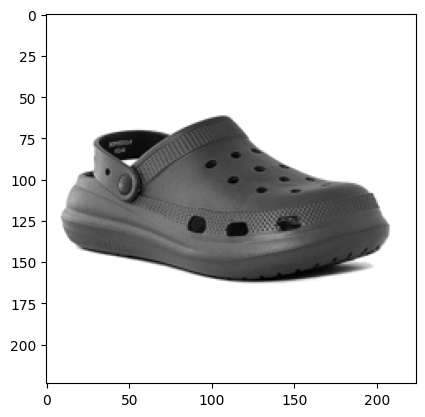

In [ ]:
image = Image.open('../images/sandal.png')  # Replace with your image path
image_resized = image.resize((224, 224))
transform = transforms.ToTensor()
image_resized = transform(image_resized)
plt.imshow(image_resized.squeeze(0), cmap="gray");

In [ ]:
image_resized = image_resized.reshape(1, 1, 224, 224)
image_resized = image_resized.cuda()

In [ ]:
nn.Softmax()(loaded_model(image_resized)).argmax()

tensor(8, device='cuda:0')

# Visualizations!

In [ ]:
def plot_kernels(kernels, n_cols):
    """
    Function to automatically plot kernels in a grid of subplots.

    :param kernels: List or numpy array of kernels to plot.
    :param n_cols: The number of columns in the grid.
    """
    n_kernels = len(kernels)

    # Calculate number of rows based on the number of kernels and columns
    n_rows = (n_kernels + n_cols - 1) // n_cols  # Equivalent to ceil(n_kernels / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), dpi=100)

    # Flatten axes array to make indexing easier
    axes = axes.flatten()

    # Plot each kernel
    for i in range(n_kernels):
        axes[i].imshow(torch.squeeze(kernels[i]).cpu().detach().numpy(), cmap="gray")
        axes[i].axis('off')  # Optional: to hide axes for better visualization

    # Hide extra axes if there are fewer kernels than subplots
    for i in range(n_kernels, len(axes)):
        axes[i].axis('off')

    plt.show()

In [ ]:
loaded_model.net[0]

Conv2d(0, 96, kernel_size=(11, 11), stride=(4, 4))

In [ ]:
first_layer = loaded_model.net[0]

In [ ]:
# This first layer has 6 kernels, each with single channel and 5x5 shape
kernels_96 = first_layer.weight
kernels_96.shape

torch.Size([96, 1, 11, 11])

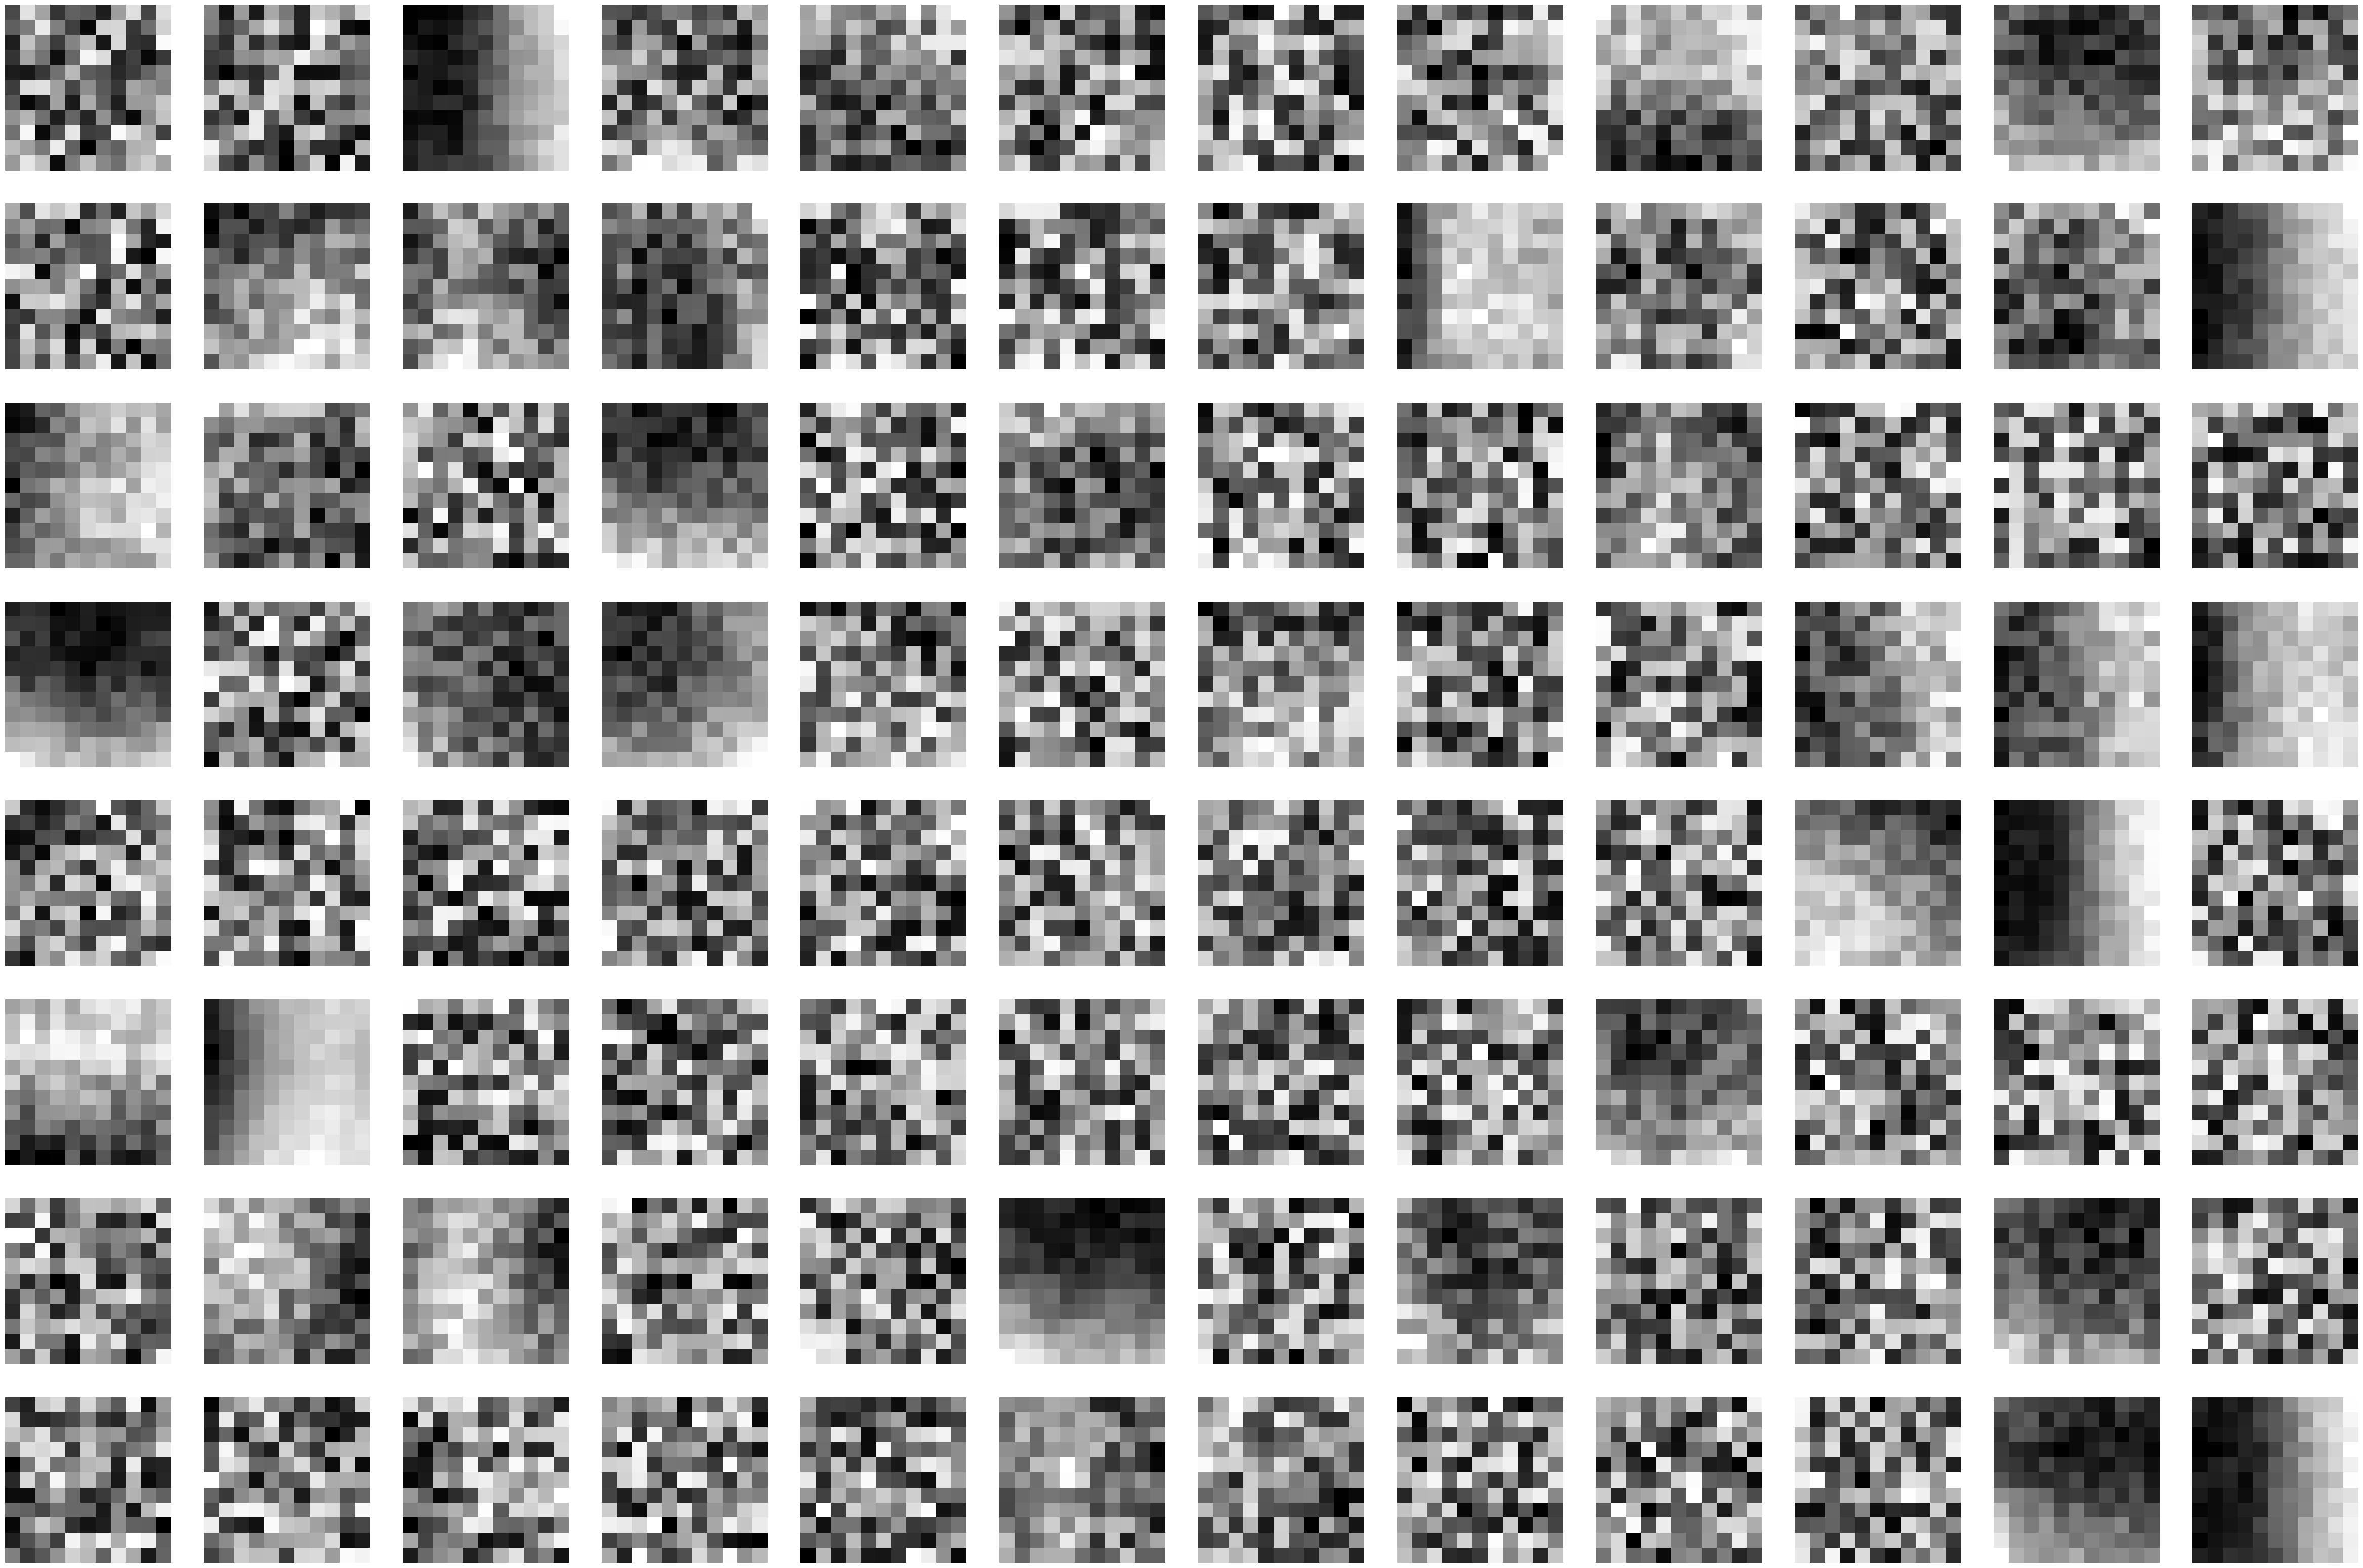

In [ ]:
# Example usage with kernels_6 (assuming kernels_6 is defined)
plot_kernels(kernels_96, n_cols=12)

Some gradients and some edges -- but nothing much interesting here!

## Image?

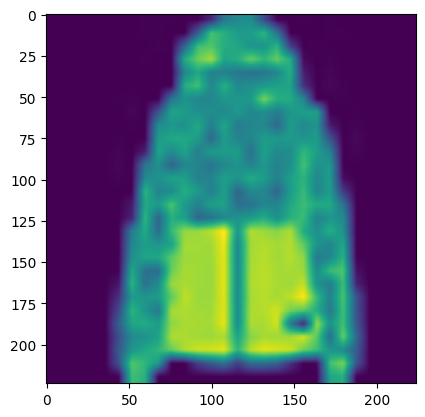

In [ ]:
sample = data.train[22][0]
plt.imshow(sample.permute(1,2,0));

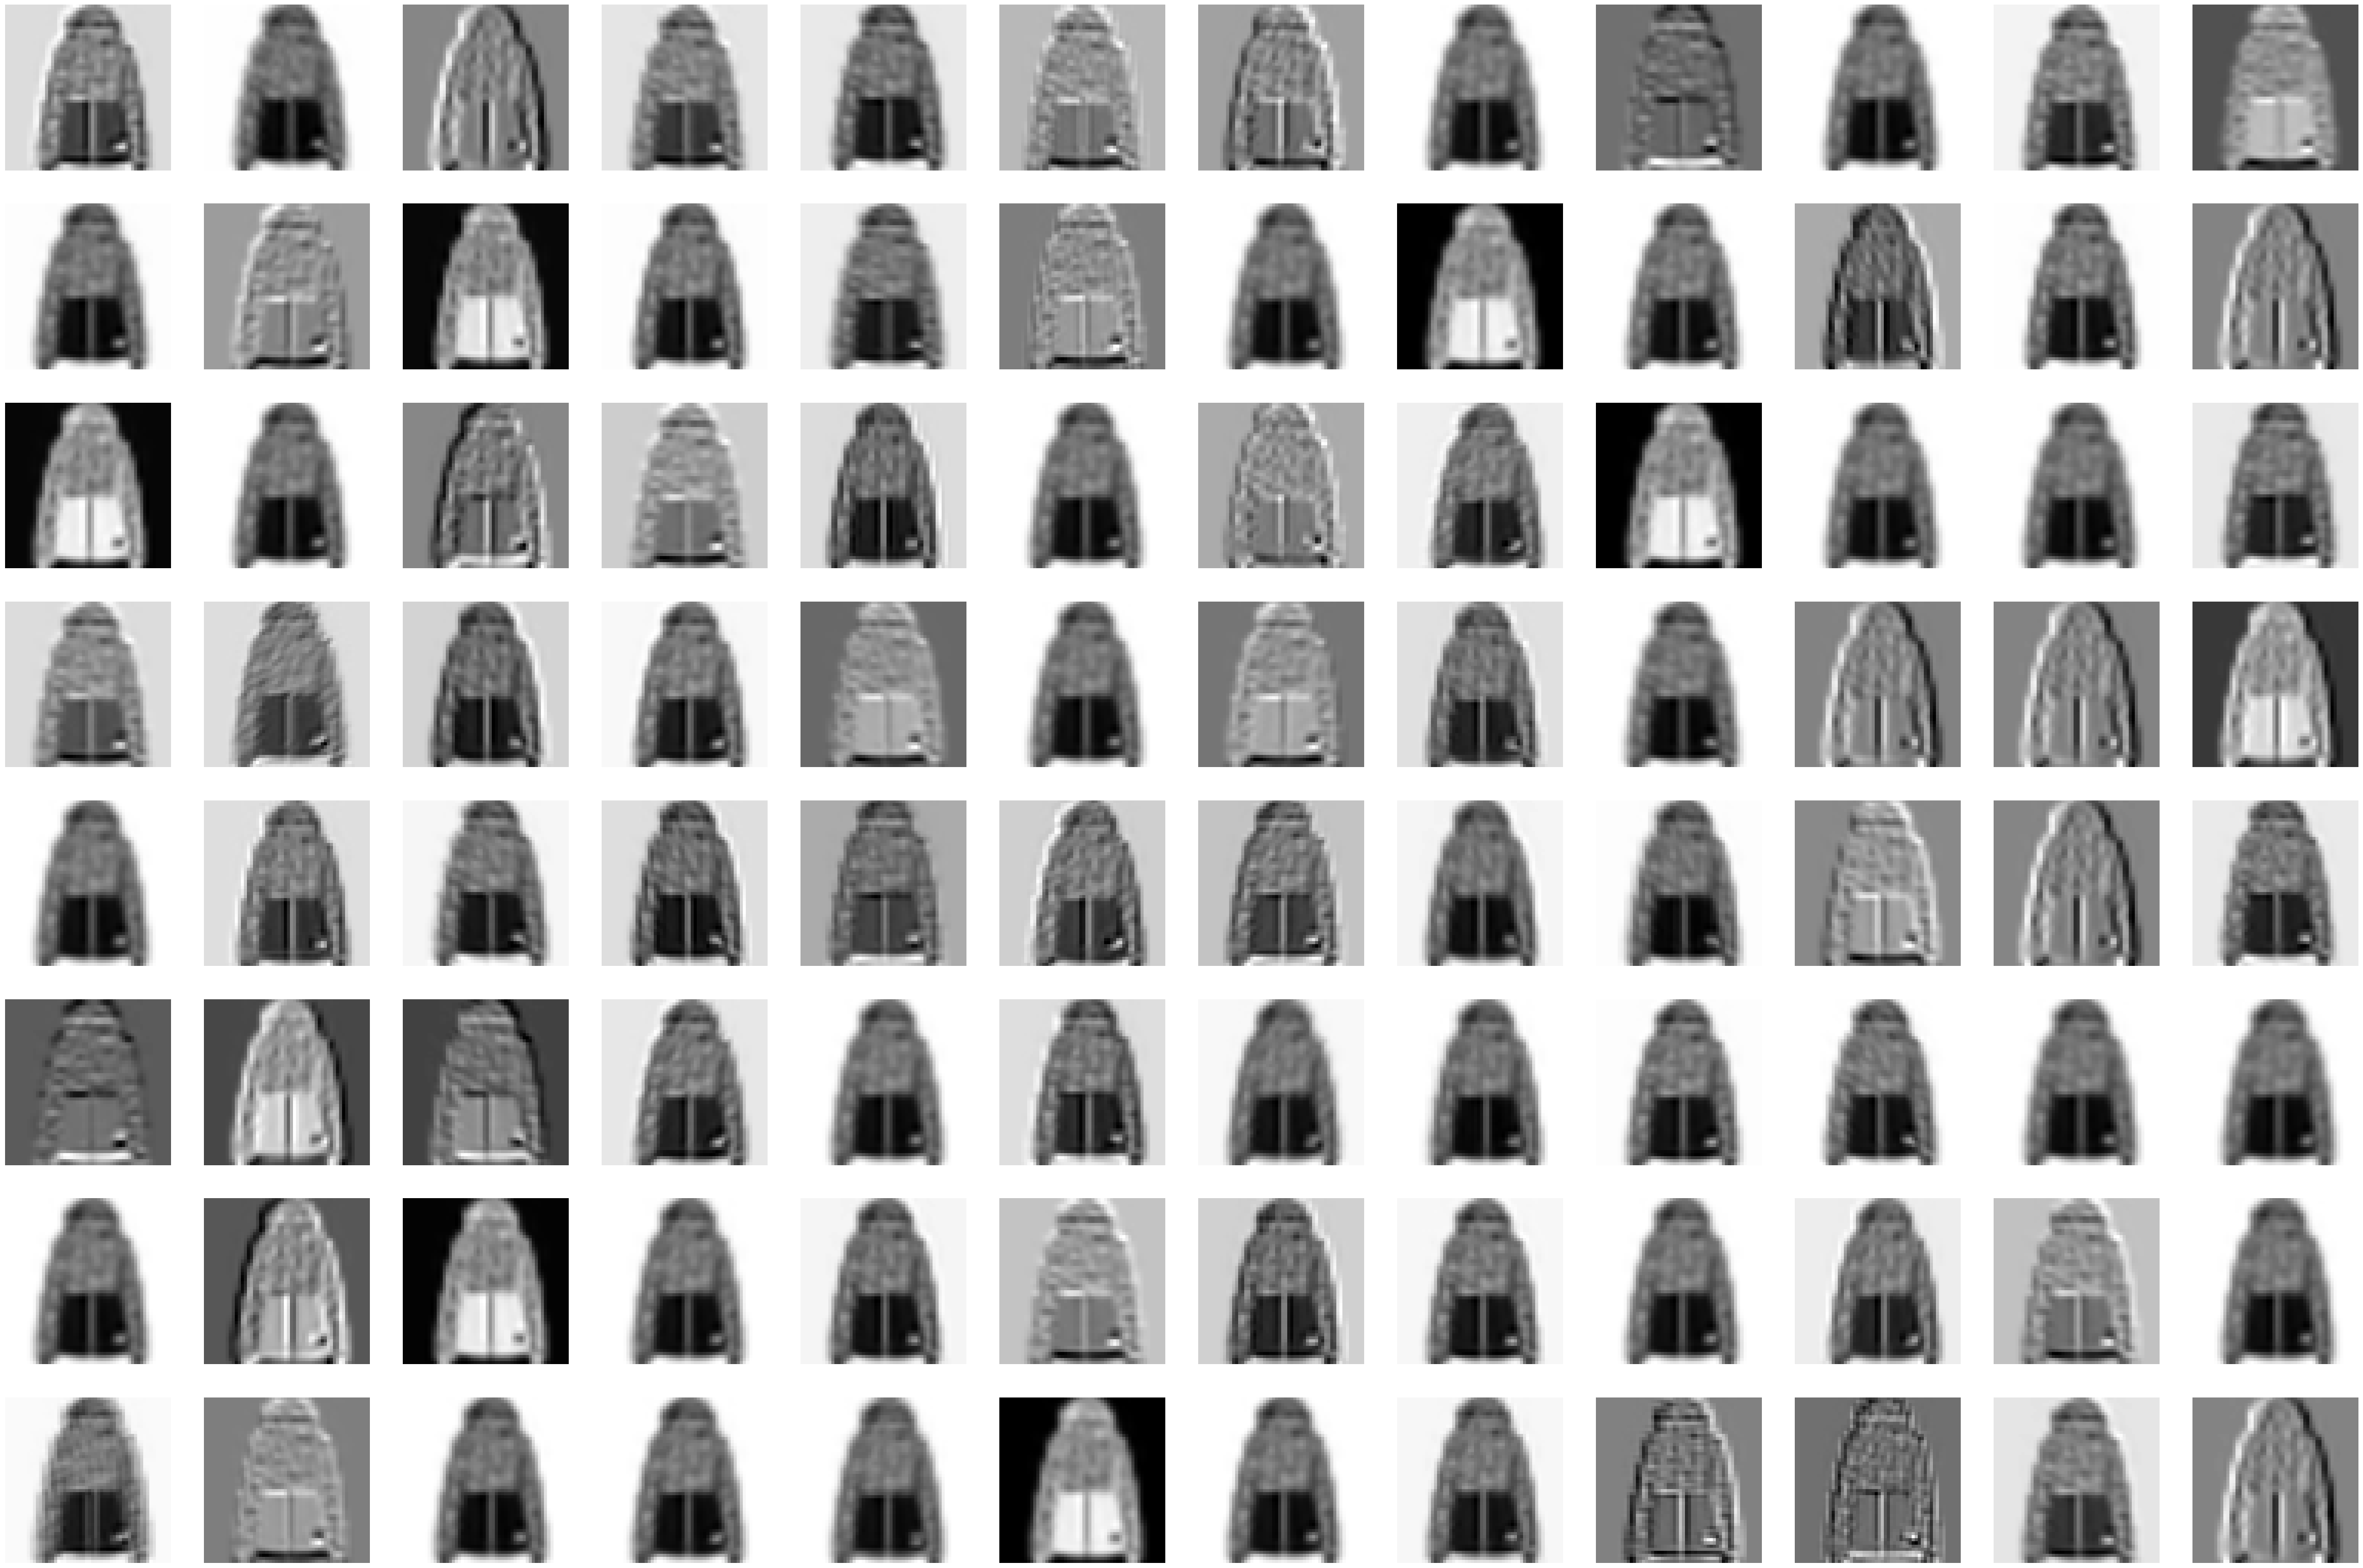

In [ ]:
sample = sample.reshape((1, 1, 224, 224))
sample = sample.to(torch.float32).cuda()

first_layer_result = first_layer(sample)
feature_mapes = first_layer_result[0]

plot_kernels(feature_mapes, n_cols=12)

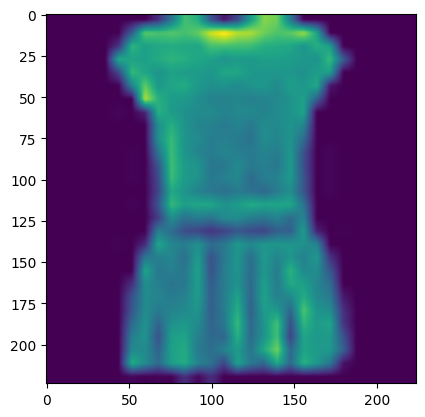

In [ ]:
sample = data.train[3][0]
plt.imshow(sample.permute(1,2,0));

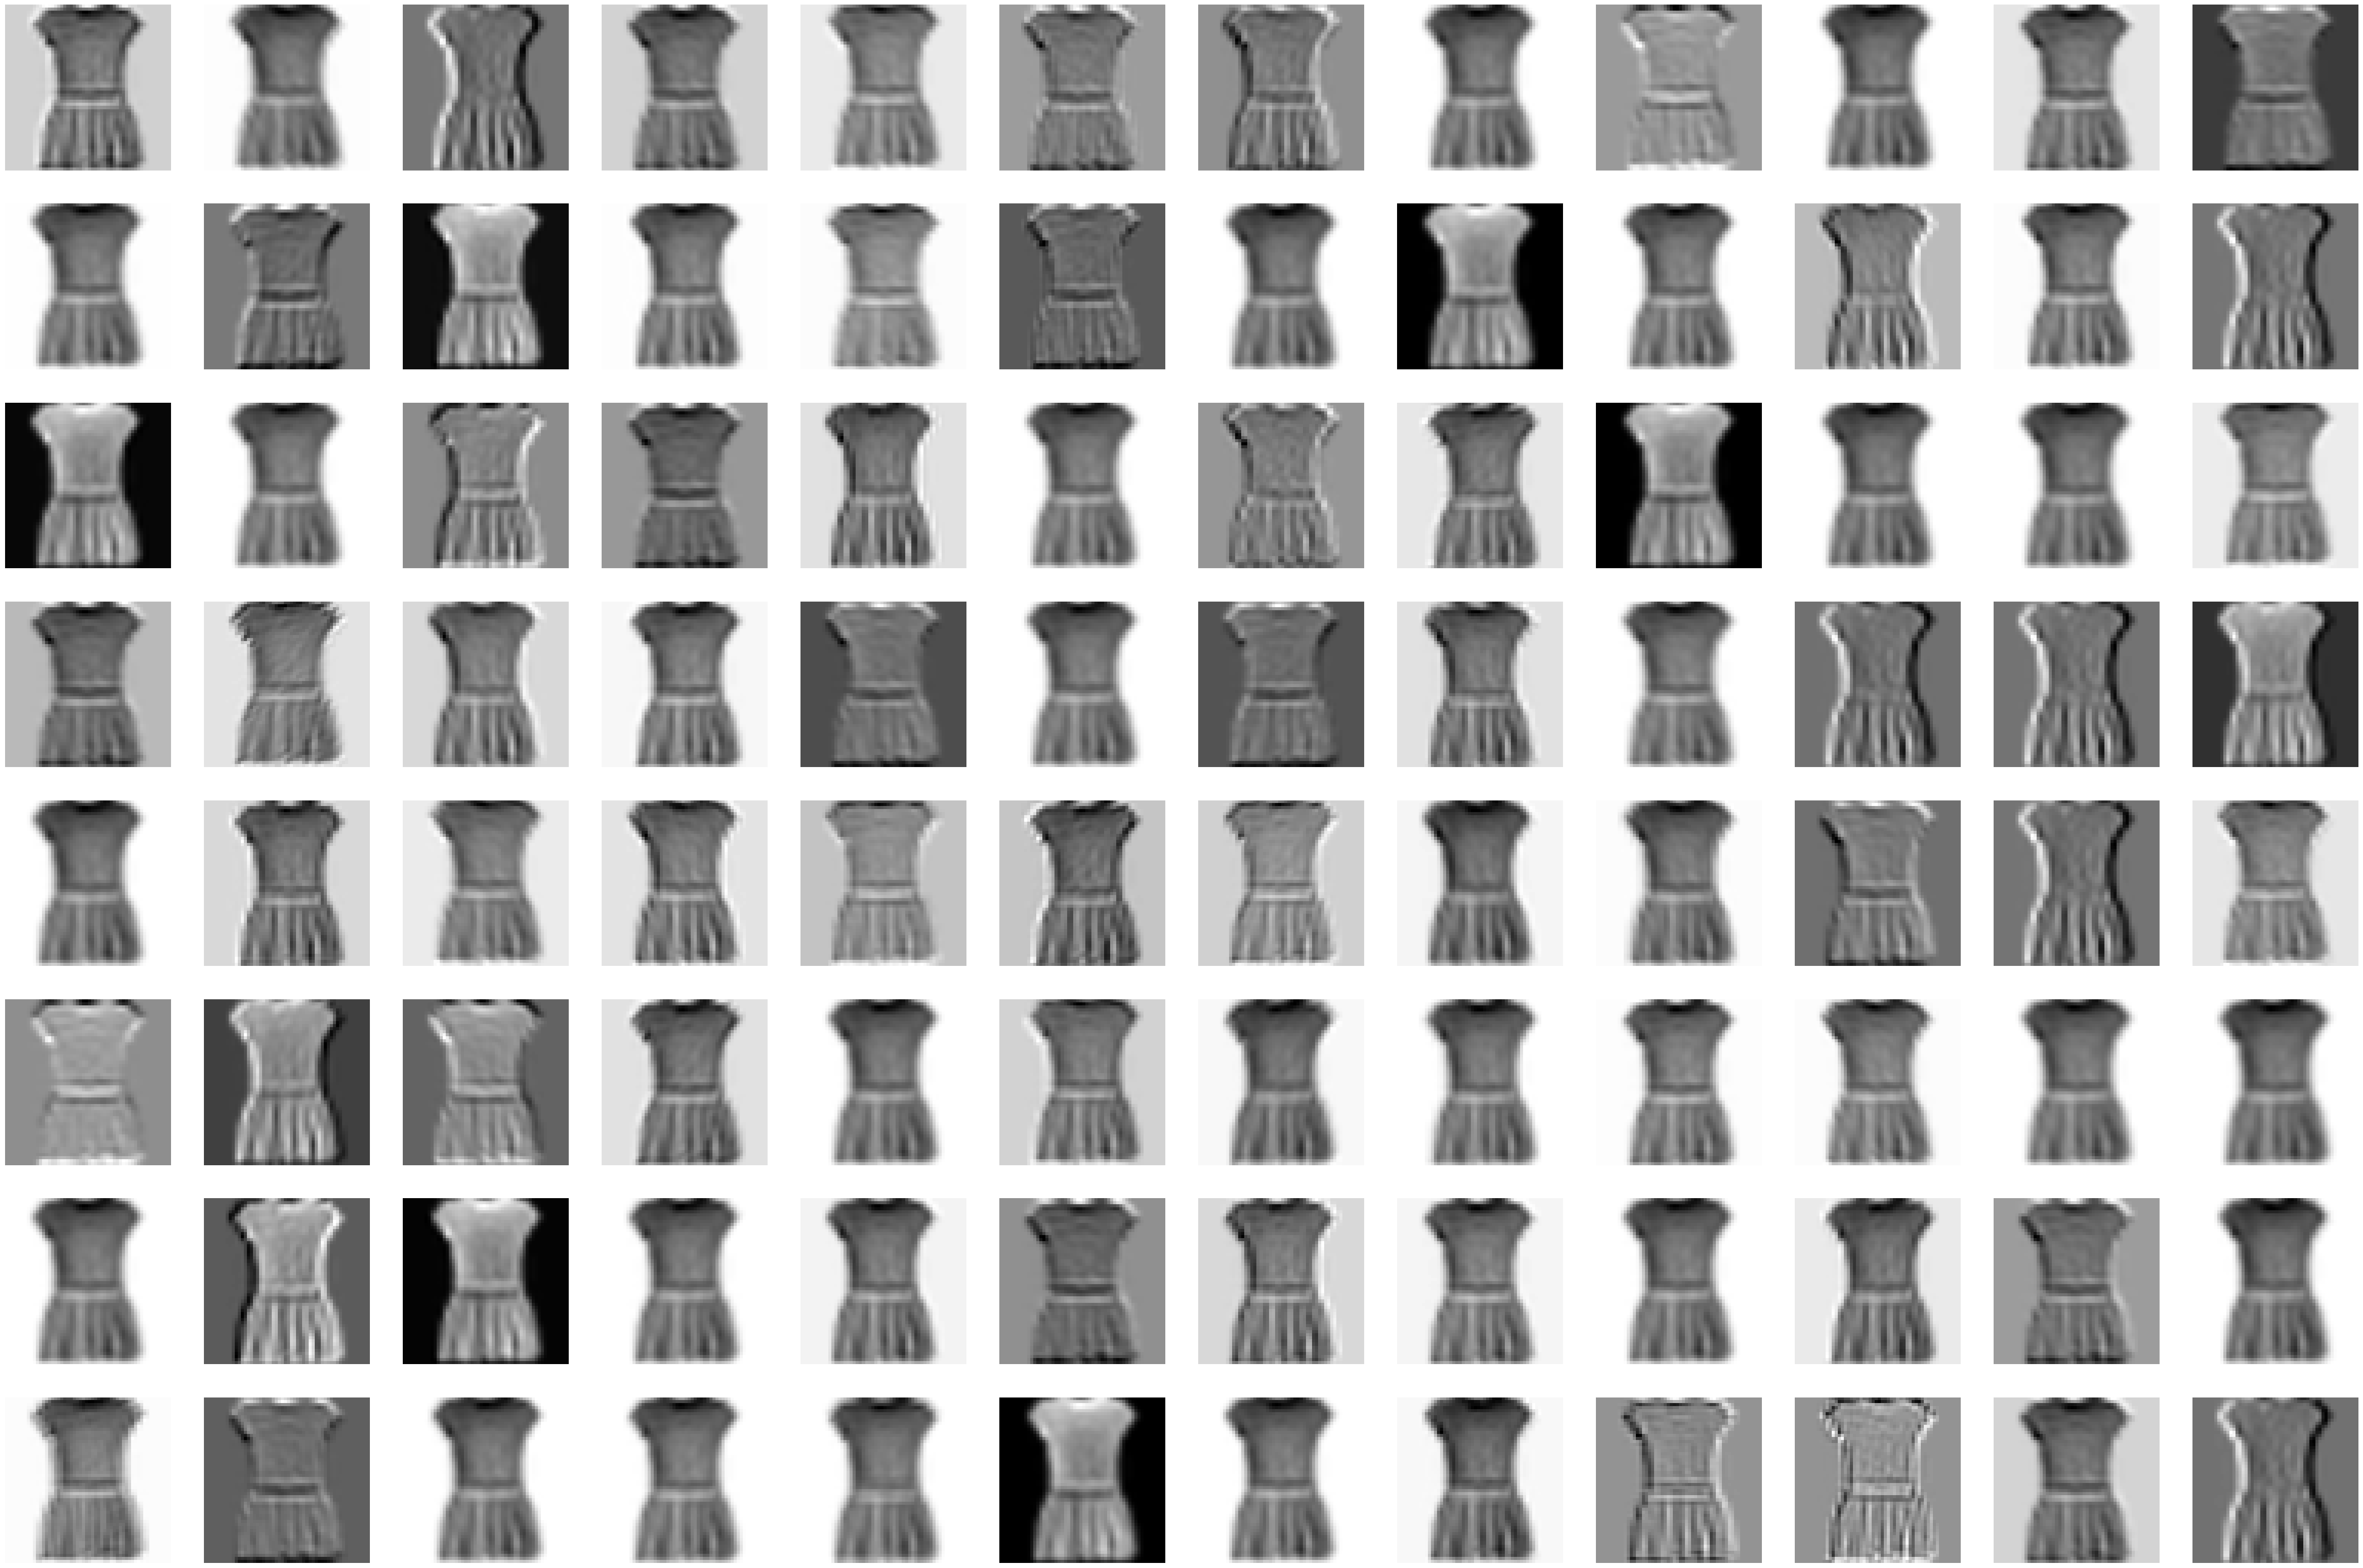

In [ ]:
sample = sample.reshape((1, 1, 224, 224))
sample = sample.to(torch.float32).cuda()

first_layer_result = first_layer(sample)
feature_mapes = first_layer_result[0]

plot_kernels(feature_mapes, n_cols=12)

Alright!

# Excercise

1. Let's resize the model so that it can train well with 28x28 images.

In [4]:
class AlexNet_mini(d2l.Classifier):
    """AlextNet model"""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=1, padding=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2),

            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2),

            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1, stride=2),

            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(),
            nn.LazyLinear(4096), nn.ReLU(),
            nn.LazyLinear(num_classes))

In [4]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    # basically we will need to *pass* something there as there are LazyLayers
    X = torch.randn(*X_shape, device="cuda")
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [20]:
model = AlexNet_mini().cuda()

# these are the **image outputs** between layers and **not** the parameters of the model to be learnt.
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 96, 28, 28])
ReLU output shape:	 torch.Size([1, 96, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 96, 14, 14])
Conv2d output shape:	 torch.Size([1, 256, 14, 14])
ReLU output shape:	 torch.Size([1, 256, 14, 14])
MaxPool2d output shape:	 torch.Size([1, 256, 7, 7])
Conv2d output shape:	 torch.Size([1, 384, 7, 7])
ReLU output shape:	 torch.Size([1, 384, 7, 7])
Conv2d output shape:	 torch.Size([1, 384, 7, 7])
ReLU output shape:	 torch.Size([1, 384, 7, 7])
Conv2d output shape:	 torch.Size([1, 256, 7, 7])
ReLU output shape:	 torch.Size([1, 256, 7, 7])
MaxPool2d output shape:	 torch.Size([1, 256, 4, 4])
Flatten output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [13]:
def calculate_output_dimension(input_size, kernel_size, padding, stride):
    output_size = ((input_size - kernel_size + 2 * padding) // stride) + 1
    return output_size

# Example usage:
input_width = input_height = 7
kernel_size = 3
padding = 1
stride = 1

output_width = calculate_output_dimension(input_width, kernel_size, padding, stride)
output_height = calculate_output_dimension(input_height, kernel_size, padding, stride)

print(f"Output Width: {output_width}")
print(f"Output Height: {output_height}")

Output Width: 7
Output Height: 7


In [21]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 37327562


In [22]:
# Iterate through the model's layers and parameters
for name, layer in model.named_modules():
    # Check if the layer has parameters (e.g., Conv2d, Linear)
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        print(f"Layer: {name}")
        for param in layer.parameters():
            print(f"  Parameter: {param.shape}")

Layer: net.0
  Parameter: torch.Size([96, 1, 11, 11])
  Parameter: torch.Size([96])
Layer: net.3
  Parameter: torch.Size([256, 96, 5, 5])
  Parameter: torch.Size([256])
Layer: net.6
  Parameter: torch.Size([384, 256, 3, 3])
  Parameter: torch.Size([384])
Layer: net.8
  Parameter: torch.Size([384, 384, 3, 3])
  Parameter: torch.Size([384])
Layer: net.10
  Parameter: torch.Size([256, 384, 3, 3])
  Parameter: torch.Size([256])
Layer: net.14
  Parameter: torch.Size([4096, 4096])
  Parameter: torch.Size([4096])
Layer: net.16
  Parameter: torch.Size([4096, 4096])
  Parameter: torch.Size([4096])
Layer: net.18
  Parameter: torch.Size([10, 4096])
  Parameter: torch.Size([10])


Point(x=10.0, y=0.8982397151898734)


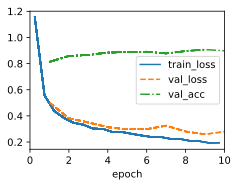

In [23]:
data = FashionMNIST(batch_size=128, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model = AlexNet_mini(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)
print(model.board.data['val_acc'][-1])

Took 3 minutes to train with 128 batch and got 89 Accuracy.

Point(x=10.0, y=0.8322093278169632)


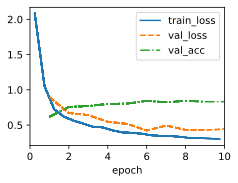

In [24]:
# Change batch size
data = FashionMNIST(batch_size=512, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model = AlexNet_mini(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)
print(model.board.data['val_acc'][-1])

Well, it is bad accuracay. But we need to also increase the epochs when we have higher batch sizes.

In [25]:
del model
torch.cuda.empty_cache()

Point(x=20.0, y=0.7298999726772308)


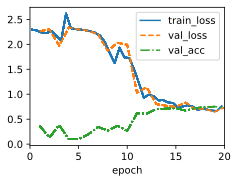

In [5]:
# Change batch size
data = d2l.FashionMNIST(batch_size=5000, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model = AlexNet_mini(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)
print(model.board.data['val_acc'][-1])